# Homework 1: Analyzing COVID-19 Data with Regression

In the coding part of this assignment we will conduct regression analysis on COVID-19 data to understand variables that affect COVID-19 growth rate. 

To complete this part of the assignment, follow along with the data loading and cleaning (running each cell as you go), looking up functions you are unfamiliar with and making sure you understand each step. While this part is not super fun, it is very important that you understand and are familiar with techniques for data manipulation so that you can use them later. When you arrive at the tasks, follow the instructions and then get started on your own research. 

Check out [this](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/) blog post for some Jupyter Notebook tips to get that work ~flowing~. Also, we use Pandas a lot in this assignment so if you are unfamiliar with this package and run into trouble, we recommend you check out a tutorial online. 


In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.dates as mdates

## Loading Data

We got our data from Johns Hopkins Hopkins University. It gives us cumulative totals for confirmed cases, deaths, and recovered cases on the country level. The most up-to-date data can be found [here](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases) 

In [168]:
raw_confirmed = pd.read_csv('Data/time_series_covid19_confirmed_global.csv')
raw_deaths = pd.read_csv('Data/time_series_covid19_deaths_global.csv')
raw_recovered = pd.read_csv('Data/time_series_covid19_recovered_global.csv')

### Take a look at the structure of the data (the other data tables have the same structure)

In [169]:
raw_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


In [170]:
# Cleaning the data

confirmed = raw_confirmed.drop(['Lat','Long'], axis = 1)
deaths = raw_deaths.drop(['Lat','Long'], axis = 1)
recovered = raw_recovered.drop(['Lat','Long'], axis = 1)

# Removing province information so we have consistent country-level resolution

def set_country_res(df):

    df_sans_provinces = df.drop('Province/State', axis=1)
    df_sans_provinces = df_sans_provinces.groupby('Country/Region').sum()
    
    return df_sans_provinces

confirmed = set_country_res(confirmed)
deaths = set_country_res(deaths)
recovered = set_country_res(recovered)

confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
Albania,0,0,0,0,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
Algeria,0,0,0,0,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
Andorra,0,0,0,0,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
Angola,0,0,0,0,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


### Now let's visualize our data! We do this to make sure that our data is loaded in properly and matches our expectations -- if the data doesn't match you expectation you either made a mistake or a discovery (both are worth your time to find out early). As you work with data, remember to visualize early and often as a sanity check.

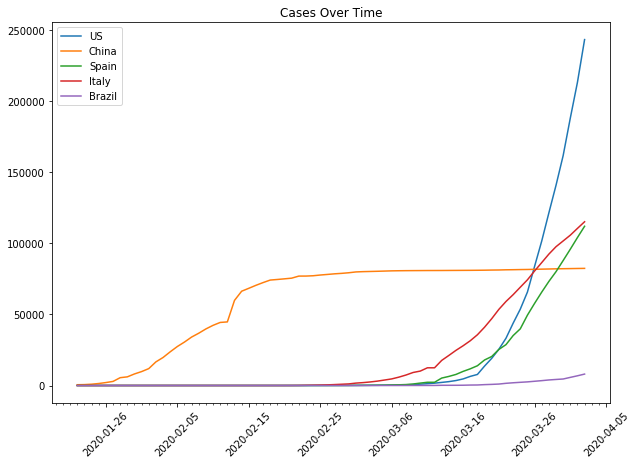

In [171]:
confirmed.columns = pd.to_datetime(confirmed.columns)

plt.figure(figsize = (10,7))
plt.xticks(rotation = 45)
plt.plot(confirmed.columns, confirmed.loc['US'], label = 'US')
plt.plot(confirmed.columns, confirmed.loc['China'], label = 'China')
plt.plot(confirmed.columns, confirmed.loc['Spain'], label = 'Spain')
plt.plot(confirmed.columns, confirmed.loc['Italy'], label = 'Italy')
plt.plot(confirmed.columns, confirmed.loc['Brazil'], label = 'Brazil')
plt.legend()

# Set xaxis tick marks to be regular
years_fmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))

plt.title('Cases Over Time')
plt.show()

### Gathering explanatory variables

In this assignment we are trying to investigate causal relationships and correlations between COVID-19 country data and possible population statistics that could affect infection and death rates. So now, we will show you how to load and join possible explanatory variables. 

It has been shown that older individuals are at [higher risk of death due to COVID-19](https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/older-adults.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fspecific-groups%2Fhigh-risk-complications%2Folder-adults.html) so we decided to investigate if the median age of a country is correlated with its death rate as an example.

In [172]:
# Load median age data
median_age = pd.read_csv('Data/median_age.csv')
median_age.drop(['Median Male','Median Female'], axis=1, inplace=True)
median_age.rename(columns={'Median':'median_age', 'Place':'Country/Region'},inplace=True)
median_age.set_index('Country/Region', drop = True, inplace=True)
median_age.head()

,median_age
Country/Region,
Monaco,53.1
Japan,47.3
Germany,47.1
Saint Pierre and Miquelon,46.5
Italy,45.5


We can now calculate the death rate for each country. To do this we decided to use 

$death \; rate = \frac{deaths}{confirmed \; cases}$

because at the time of writing this assignment, the number of resolved cases was very low and likely underreported. If we had better data, a more accurate representation of the death rate would be to use resolved cases in the denominator (where $resolved \; cases = recovered + deaths$)



In [173]:
# Calculate death rate for each country

# Get most recent numbers for recovered and deaths (last column in the data table)
total_confirmed = confirmed[confirmed.columns[-1]]
total_deaths = deaths[deaths.columns[-1]]

death_rate = pd.Series(dtype = float)

# Calculating death rate
if (total_deaths.index == total_confirmed.index).all():
    death_rate = total_deaths/(total_confirmed + total_deaths)
else:
    print('Whoops, looks like your countries dont match')

# Drop countries that have a null death rate (don't have any cases)
death_rate.dropna(inplace=True)

death_rate = pd.DataFrame(death_rate)
death_rate.rename(columns={death_rate.columns[0]:'death_rate'},inplace=True)

A useful tool when working with multiple data tables is the merge function. This function merges two data tables (or columns from data tables) on a column or index of your choosing. One must be careful when merging because you can easily lose or multiply your data because of duplicate or mismatching keys. For this reason, it is important to always check the size of your new data table compared to the old ones. 

You can find more information about the pandas merge function [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) and a more in depth explanation of merges [here](https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/).

In [174]:
# Merging death rate and median age 
naive_merge = median_age.merge(death_rate, left_index=True, right_index=True)

We called our first merge a naive merge because we made the assumption that our two different data sources had all the same countries and named the countries the same. We will check that assumption in the next cell.

In [175]:
# Finding how many countries we lost in our naive merge
print(f'We lost {death_rate.shape[0] - naive_merge.shape[0]} countries in our naive merge')

# Finding the countries we lost
right_merge = median_age.merge(death_rate,left_index=True, right_index=True, how='right')
right_merge[right_merge.median_age.isnull()]

We lost 18 countries in our naive merge


,median_age,death_rate
Country/Region,,
Bahamas,NaN,0.040000
Burma,NaN,0.047619
Cabo Verde,NaN,0.142857
Congo (Brazzaville),NaN,0.083333
Congo (Kinshasa),NaN,0.088435
Cote d'Ivoire,NaN,0.005128
Czechia,NaN,0.011276
Diamond Princess,NaN,0.015214
Eswatini,NaN,0.000000


Of the countries that we lost, we are going to add back the US and South Korea (which is called 'Korea, South' in the data set for some reason). To do this, we simply need to make the names match. 

In [176]:
# To find the corresponding names in the median_age table, we guessed the obvious names 
# and they worked: 'United States' and 'South Korea'

# But if you can't find a name you can try this
# for country in median_age.index:
#     print(country)

# Now we will rename them in the median_age data (so it is consistent with the rest of our data)
median_age.rename(index={'United States':'US','South Korea':'Korea, South'}, inplace=True)

# Redoing our merge
deaths_and_age = median_age.merge(death_rate,left_index=True, right_index=True)

# Make sure it worked, we should have 2 fewer missing countries
print(f'We lost {death_rate.shape[0] - deaths_and_age.shape[0]} countries in our merge')



We lost 16 countries in our merge


### Now that we have workable data let's visualize it.

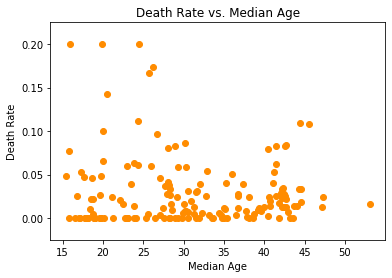

In [177]:
plt.scatter(deaths_and_age.median_age, deaths_and_age.death_rate, color='darkorange')
plt.ylabel('Death Rate')
plt.xlabel('Median Age')
plt.title('Death Rate vs. Median Age')
plt.show()

### Based on our initial scatter plot a linear relationship doesn't look super promising but let's try it anyway

You can find more information about the package we used for the linear regression [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).

p-values: 0.35339370626947875
R^2: 0.005285847299216592
Slope: -0.00032013215700298314


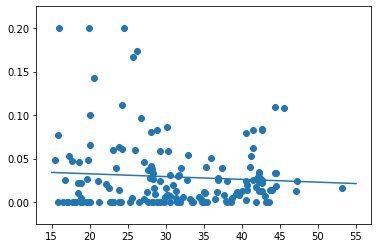

In [178]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(deaths_and_age.median_age, deaths_and_age.death_rate)
predictions = np.linspace(15,55,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(deaths_and_age.median_age, deaths_and_age.death_rate)
plt.plot(np.linspace(15,55,5), predictions)
plt.show()


As we predicted, our linear regression was not successful (as of the writing of this assignment). We encourage you to do your own research on methods of assessing regressions if you don't already have experience in this area and the grutors are happy to talk about it as well. Our regression above is likely an example of 'garbage in, garbage out'. This means that you can't get good information from bad data and coronavirus data is anything but consistent across countries, so you need to be careful about conclusions you draw from your analysis.

Now we have to ask ourselves if we truly believe that age is not a factor in death rate or if our data is misrepresenting reality. Now this is where you come in. You may have noticed that some countries have extremely high death rates that are inconsistent with what we know about the virus. This is likely because the sample size is far too small and furthermore is biased towards critical cases due to a lack of testing. While we can't fix the testing problem, we can try to make the data more reliable by filtering based on sample size. 

Your first task is to filter the data based on a minimum sample size that you deem appropriate (we chose 1000 on March 28th) then re-run the regression and interpret the results. Don't worry if you don't get statistically significant/logical results. 

__Don't forget to save important graphs and statistics for your deliverable.__


## Task 1: Filter on Sample Size and Re-Run Regression


In [179]:
# Get an idea of the numbers of resolved cases for most countries
total_confirmed.describe()

count       181.000000
mean       5597.552486
std       23883.385484
min           1.000000
25%          20.000000
50%         233.000000
75%        1317.000000
max      243453.000000
Name: 2020-04-02 00:00:00, dtype: float64

In [180]:
filtered_confirmed = total_confirmed[total_confirmed >= 1000]
small_sample_confirmed = total_confirmed[total_confirmed < 1000]

In [181]:
filtered_confirmed.head()

Country/Region
Argentina     1133
Australia     5116
Austria      11129
Belgium      15348
Brazil        8044
Name: 2020-04-02 00:00:00, dtype: int64

We know have 52 countries that have 1000 cases or more:

In [182]:
filtered_confirmed.shape

(52,)

In [183]:
filtered_countries = list(filtered_confirmed.index.values)
unfiltered_countries = list(small_sample_confirmed.index.values)
filtered_deaths = deaths[deaths.columns[-1]].drop(labels = unfiltered_countries)

In [184]:
filtered_deaths.shape == filtered_confirmed.shape

True

In [185]:
new_death_rate = pd.Series(dtype = float)

# Calculating death rate
if (filtered_deaths.index == filtered_confirmed.index).all():
    new_death_rate = filtered_deaths/(filtered_confirmed + filtered_deaths)
else:
    print('Whoops, looks like your countries dont match')

# Drop countries that have a null death rate (don't have any cases)
new_death_rate.dropna(inplace=True)

new_death_rate = pd.DataFrame(new_death_rate)
new_death_rate.rename(columns={new_death_rate.columns[0]:'death_rate'},inplace=True)

In [186]:
new_deaths_and_age = median_age.merge(new_death_rate,left_index=True, right_index=True)

new_deaths_and_age.dropna()

print(new_deaths_and_age.shape)

(51, 2)


In [187]:
new_deaths_and_age_countries = list(new_deaths_and_age.index.values)
new_deaths_and_age_countries.sort() == filtered_countries.sort()

True

p-values: 0.22587212168821744
R^2: 0.0297855879051554
Slope: 0.000665030949548829


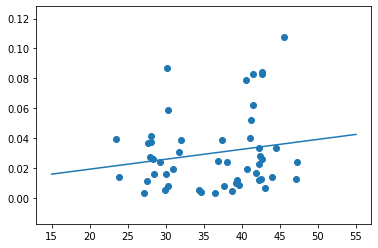

In [188]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(new_deaths_and_age.median_age, new_deaths_and_age.death_rate)
predictions = np.linspace(15,55,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(new_deaths_and_age.median_age, new_deaths_and_age.death_rate)
plt.plot(np.linspace(15,55,5), predictions)
plt.show()

## Task 2: Find Your Own Data
Now, armed with the code above, you should pose a research question, find and download your own data from the internet, import it and run regressions (at least 2) to investigate your question. For each regression, write what you expect the relationship to be before you run the regression, graph the data, discuss how your results support/refute your initial hypothesis, and what you would need to be more sure of your results. 

You are welcome to continue working at a global scale, but there is also state by state data (and even county level data) in the United States which might yield more interesting results [here](https://covidtracking.com/?fbclid=IwAR3WwZ1nX8qhwJkAi1uYahgpyV94V3xPs0v_RzBBycMPB7p01DMKyDcc9Bk).

There is a wealth of demographic data on the internet that you can couple with the COVID-19 data. You don't need to limit yourself to looking at the death rate, but you can look at any trends with respect to COVID-19 you find interesting.

You can run linear regressions, transform your data (to fit an exponential or quadratic function, for example), run a Multiple Linear Regression, or anything else the questions you want to answer require. Feel free to use all internet resources (as long as you don't copy graphs and results), and the grutors are happy to answer any questions you have.

### Make sure to save graphs and statistics!

## Research Question:
Is the death rate of US states correlated with their racial demographics?  

## Data: 
I test the relationship between the racial demographics of states and their death rates. I obtained data from World Population Review ([link](https://worldpopulationreview.com/states/states-by-race/)) about the racial demographics of each state. I also used data from The Covid Tracking Project ([link](https://covidtracking.com/data)) which included the number of cases and deaths of each state.

## Methods:
I use linear regression to evaluate correlation between the racial demographics of each state. The code is below:

In [189]:
state_covid_data = pd.read_csv('Data/states_current.csv')
state_race_data = pd.read_csv('Data/state_race_data.csv')

In [190]:
state_covid_data.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,negative,pending,...,death,hospitalized,total,totalTestResults,posNeg,fips,dateModified,dateChecked,notes,hash
0,AK,257,1.0,1.0,1.0,1.0,A,4.0,7475,NaN,...,8.0,31.0,7732,7732,7732,2,2020-04-11T18:45:00Z,2020-04-11T20:39:00Z,"Please stop using the ""total"" field. Use ""tota...",9a40c45c0a168b48c7e6db4484946abc1dee37bb
1,AL,3262,1.0,1.0,0.0,1.0,B,3.0,18058,NaN,...,93.0,402.0,21320,21320,21320,1,2020-04-11T04:00:00Z,2020-04-12T02:51:00Z,"Please stop using the ""total"" field. Use ""tota...",89141ccadad5aa376d34b633a4a8ec97c66a668b
2,AR,1226,1.0,1.0,1.0,1.0,A,4.0,17352,NaN,...,24.0,130.0,18578,18578,18578,5,2020-04-11T17:20:00Z,2020-04-11T18:38:00Z,"Please stop using the ""total"" field. Use ""tota...",ca8cb0bd47947c73ac07b843155d113ef0bea032
3,AZ,3393,1.0,1.0,0.0,1.0,B,3.0,37137,NaN,...,108.0,NaN,40530,40530,40530,4,2020-04-11T04:00:00Z,2020-04-12T02:52:00Z,"Please stop using the ""total"" field. Use ""tota...",87f13b79fbc8dc86bb701d2b879e38c37371ec55
4,CA,20615,1.0,1.0,0.0,1.0,B,3.0,162371,13200.0,...,609.0,NaN,196186,182986,182986,6,2020-04-10T04:00:00Z,2020-04-12T03:23:00Z,"Please stop using the ""total"" field. Use ""tota...",75c29fc5f48a8f455022e2ae3f6119e0d3f2961a


In [191]:
state_race_data.head()

,State,Total,White,Black,Native,Asian,Islander,OtherRace,TwoOrMoreRaces
0,Alabama,4864680,3317453,1293186,25576,64609,2182,70055,91619
1,Alaska,738516,478834,24129,106660,46556,8849,11027,62461
2,Arizona,6946685,5364141,305259,309580,228887,14112,471823,252883
3,Arkansas,2990671,2302874,460970,20037,43988,7969,78981,75852
4,California,39148760,23529068,2267875,296475,5604339,153366,5415410,1882227


In [192]:
races = ["White", "Black", "Native", "Asian", "Islander", "OtherRace", "TwoOrMoreRaces"]
for race in races:
    column_name = "Percent_" + race
    state_race_data[column_name] = state_race_data[race] / state_race_data["Total"]

state_race_data = state_race_data.drop(columns = races)
state_race_data = state_race_data.drop(columns = ["Total"])
state_race_data.head()

,State,Percent_White,Percent_Black,Percent_Native,Percent_Asian,Percent_Islander,Percent_OtherRace,Percent_TwoOrMoreRaces
0,Alabama,0.681947,0.265832,0.005257,0.013281,0.000449,0.014401,0.018834
1,Alaska,0.648373,0.032672,0.144425,0.063040,0.011982,0.014931,0.084576
2,Arizona,0.772187,0.043943,0.044565,0.032949,0.002031,0.067921,0.036403
3,Arkansas,0.770019,0.154136,0.006700,0.014708,0.002665,0.026409,0.025363
4,California,0.601017,0.057930,0.007573,0.143155,0.003918,0.138329,0.048079


The dictionary below is from Roger Allen's [Github](https://gist.github.com/rogerallen/1583593).

In [193]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [194]:
# Replaces 
state_race_data = state_race_data.replace({"State": us_state_abbrev})

In [195]:
state_race_data.head()

,State,Percent_White,Percent_Black,Percent_Native,Percent_Asian,Percent_Islander,Percent_OtherRace,Percent_TwoOrMoreRaces
0,AL,0.681947,0.265832,0.005257,0.013281,0.000449,0.014401,0.018834
1,AK,0.648373,0.032672,0.144425,0.063040,0.011982,0.014931,0.084576
2,AZ,0.772187,0.043943,0.044565,0.032949,0.002031,0.067921,0.036403
3,AR,0.770019,0.154136,0.006700,0.014708,0.002665,0.026409,0.025363
4,CA,0.601017,0.057930,0.007573,0.143155,0.003918,0.138329,0.048079


In [196]:
# Merging state racial data with state covid data by state
state_data_merge = state_covid_data.merge(state_race_data, left_on='state', right_on='State')

In [197]:
state_data_merge.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,negative,pending,...,notes,hash,State,Percent_White,Percent_Black,Percent_Native,Percent_Asian,Percent_Islander,Percent_OtherRace,Percent_TwoOrMoreRaces
0,AK,257,1.0,1.0,1.0,1.0,A,4.0,7475,NaN,...,"Please stop using the ""total"" field. Use ""tota...",9a40c45c0a168b48c7e6db4484946abc1dee37bb,AK,0.648373,0.032672,0.144425,0.063040,0.011982,0.014931,0.084576
1,AL,3262,1.0,1.0,0.0,1.0,B,3.0,18058,NaN,...,"Please stop using the ""total"" field. Use ""tota...",89141ccadad5aa376d34b633a4a8ec97c66a668b,AL,0.681947,0.265832,0.005257,0.013281,0.000449,0.014401,0.018834
2,AR,1226,1.0,1.0,1.0,1.0,A,4.0,17352,NaN,...,"Please stop using the ""total"" field. Use ""tota...",ca8cb0bd47947c73ac07b843155d113ef0bea032,AR,0.770019,0.154136,0.006700,0.014708,0.002665,0.026409,0.025363
3,AZ,3393,1.0,1.0,0.0,1.0,B,3.0,37137,NaN,...,"Please stop using the ""total"" field. Use ""tota...",87f13b79fbc8dc86bb701d2b879e38c37371ec55,AZ,0.772187,0.043943,0.044565,0.032949,0.002031,0.067921,0.036403
4,CA,20615,1.0,1.0,0.0,1.0,B,3.0,162371,13200.0,...,"Please stop using the ""total"" field. Use ""tota...",75c29fc5f48a8f455022e2ae3f6119e0d3f2961a,CA,0.601017,0.057930,0.007573,0.143155,0.003918,0.138329,0.048079


In [198]:
# Creates a new variable that is the total tests conducted per state
state_data_merge["total_confirmed"] = state_data_merge.positive + state_data_merge.negative

# Calculates the death rate
state_data_merge["death_rate"] = state_data_merge.death / state_data_merge.total_confirmed

state_data_merge.head()

,state,positive,positiveScore,negativeScore,negativeRegularScore,commercialScore,grade,score,negative,pending,...,State,Percent_White,Percent_Black,Percent_Native,Percent_Asian,Percent_Islander,Percent_OtherRace,Percent_TwoOrMoreRaces,total_confirmed,death_rate
0,AK,257,1.0,1.0,1.0,1.0,A,4.0,7475,NaN,...,AK,0.648373,0.032672,0.144425,0.063040,0.011982,0.014931,0.084576,7732,0.001035
1,AL,3262,1.0,1.0,0.0,1.0,B,3.0,18058,NaN,...,AL,0.681947,0.265832,0.005257,0.013281,0.000449,0.014401,0.018834,21320,0.004362
2,AR,1226,1.0,1.0,1.0,1.0,A,4.0,17352,NaN,...,AR,0.770019,0.154136,0.006700,0.014708,0.002665,0.026409,0.025363,18578,0.001292
3,AZ,3393,1.0,1.0,0.0,1.0,B,3.0,37137,NaN,...,AZ,0.772187,0.043943,0.044565,0.032949,0.002031,0.067921,0.036403,40530,0.002665
4,CA,20615,1.0,1.0,0.0,1.0,B,3.0,162371,13200.0,...,CA,0.601017,0.057930,0.007573,0.143155,0.003918,0.138329,0.048079,182986,0.003328


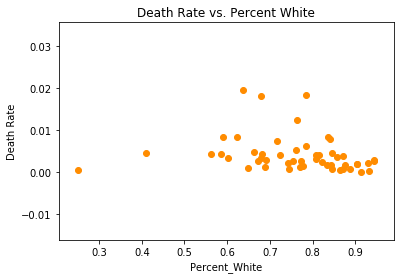

In [199]:
plt.scatter(state_data_merge.Percent_White, state_data_merge.death_rate, color='darkorange')
plt.ylabel('Death Rate')
plt.xlabel('Percent_White')
plt.title('Death Rate vs. Percent White')
plt.show()

I have heard that the death rate for African Americans is higher than for other races (in the United States). Consequently, I expect the linear regression to have a positive slope for the regression involving percent of African Americans in a state, implying that a higher percentage of African Americans in a state is correlated with a higher death rate.

**White Americans**:

p-values: 0.15732967274657017
R^2: 0.04038912085062611
Slope: -0.006546760399776916


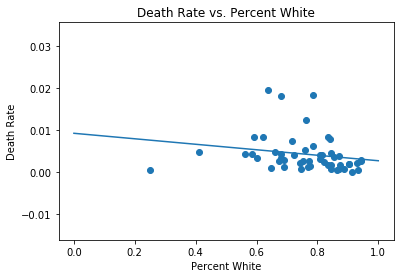

In [200]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(state_data_merge.Percent_White, state_data_merge.death_rate)
predictions = np.linspace(0,1,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(state_data_merge.Percent_White, state_data_merge.death_rate)
plt.plot(np.linspace(0,1,5), predictions)
plt.ylabel('Death Rate')
plt.xlabel('Percent White')
plt.title('Death Rate vs. Percent White')
plt.show()

**African Americans**:

p-values: 0.05467769976659751
R^2: 0.07328794117490076
Slope: 0.011160990949278107


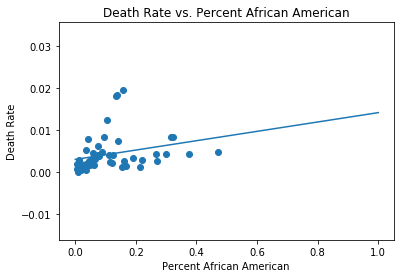

In [201]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(state_data_merge.Percent_Black, state_data_merge.death_rate)
predictions = np.linspace(0,1,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(state_data_merge.Percent_Black, state_data_merge.death_rate)
plt.plot(np.linspace(0,1,5), predictions)
plt.ylabel('Death Rate')
plt.xlabel('Percent African American')
plt.title('Death Rate vs. Percent African American')
plt.show()

**Asian Americans**:

p-values: 0.5606991695480468
R^2: 0.00695457205263117
Slope: 0.00672949115372377


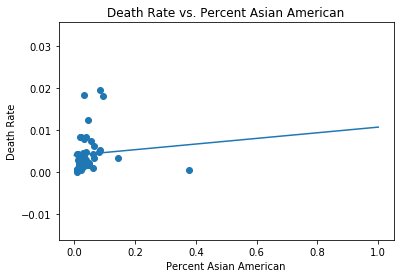

In [202]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(state_data_merge.Percent_Asian, state_data_merge.death_rate)
predictions = np.linspace(0,1,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(state_data_merge.Percent_Asian, state_data_merge.death_rate)
plt.plot(np.linspace(0,1,5), predictions)
plt.ylabel('Death Rate')
plt.xlabel('Percent Asian American')
plt.title('Death Rate vs. Percent Asian American')
plt.show()

**Two or more races**:

p-values: 0.38322545944903375
R^2: 0.015553624172967231
Slope: -0.01713304068763583


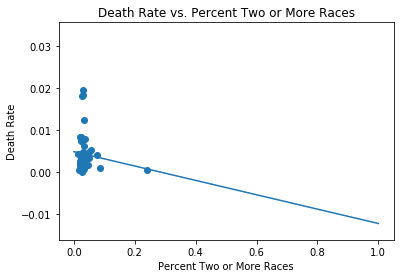

In [203]:
# Linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(state_data_merge.Percent_TwoOrMoreRaces, state_data_merge.death_rate)
predictions = np.linspace(0,1,5) * slope + intercept
print(f'p-values: {p_value}')
print(f'R^2: {r_value*r_value}')
print(f'Slope: {slope}')

# Plot Results
plt.scatter(state_data_merge.Percent_TwoOrMoreRaces, state_data_merge.death_rate)
plt.plot(np.linspace(0,1,5), predictions)
plt.ylabel('Death Rate')
plt.xlabel('Percent Two or More Races')
plt.title('Death Rate vs. Percent Two or More Races')
plt.show()

## Discussion:
The regression shows a negative slope for the model involing white Americans and people of two or more races, and a negative slope for the model involving African Americans and Asian Americans. This demonstrates support for my hypothesis, since the regression involving African Americans had a positive slope. However, I cannot draw too many conclusions from these results given the low R^2 value of the regression models.

(Summary)
## Research Question:
Is the death rate of US states correlated with their racial demographics?  

## Data: 
I test the relationship between the racial demographics of states and their death rates. I obtained data from World Population Review ([link](https://worldpopulationreview.com/states/states-by-race/)) about the racial demographics of each state. I also used data from The Covid Tracking Project ([link](https://covidtracking.com/data)) which included the number of cases and deaths of each state.

## Methods:
I use linear regression to evaluate correlation between the racial demographics of each state. The code is below:
    
## Discussion:
The regression shows a negative slope for the model involing white Americans and people of two or more races, and a negative slope for the model involving African Americans and Asian Americans. This demonstrates support for my hypothesis, since the regression involving African Americans had a positive slope. However, I cannot draw too many conclusions from these results given the low R^2 value of the regression models.